## Import modules

In [1]:
import pandas as pd
import numpy as np
import io, os, sys, types
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight, resample
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, auc, accuracy_score, roc_auc_score, confusion_matrix, mean_squared_error, roc_curve
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import math
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

# def find_notebook(fullname, path=None):
#     """find a notebook, given its fully qualified name and an optional path

#     This turns "foo.bar" into "foo/bar.ipynb"
#     and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
#     does not exist.
#     """
#     name = fullname.rsplit('.', 1)[-1]
#     if not path:
#         path = ['']
#     for d in path:
#         nb_path = os.path.join(d, name + ".ipynb")
#         if os.path.isfile(nb_path):
#             return nb_path
#         # let import Notebook_Name find "Notebook Name.ipynb"
#         nb_path = nb_path.replace("_", " ")
#         if os.path.isfile(nb_path):
#             return nb_path


# class NotebookLoader(object):
#     """Module Loader for Jupyter Notebooks"""
#     def __init__(self, path=None):
#         self.shell = InteractiveShell.instance()
#         self.path = path

#     def load_module(self, fullname):
#         """import a notebook as a module"""
#         path = find_notebook(fullname, self.path)

#         print ("importing Jupyter notebook from %s" % path)

#         # load the notebook object
#         with io.open(path, 'r', encoding='utf-8') as f:
#             nb = current.read(f, 'json')


#         # create the module and add it to sys.modules
#         # if name in sys.modules:
#         #    return sys.modules[name]
#         mod = types.ModuleType(fullname)
#         mod.__file__ = path
#         mod.__loader__ = self
#         mod.__dict__['get_ipython'] = get_ipython
#         sys.modules[fullname] = mod

#         # extra work to ensure that magics that would affect the user_ns
#         # actually affect the notebook module's ns
#         save_user_ns = self.shell.user_ns
#         self.shell.user_ns = mod.__dict__

#         try:
#             for cell in nb.worksheets[0].cells:
#                 if cell.cell_type == 'code' and cell.language == 'python':
#                 # transform the input to executable Python
#                     code = self.shell.input_transformer_manager.transform_cell(cell.input)
#                     # run the code in themodule
#                     exec(code, mod.__dict__)
#         finally:
#             self.shell.user_ns = save_user_ns
#         return mod


# class NotebookFinder(object):
#     """Module finder that locates Jupyter Notebooks"""
#     def __init__(self):
#         self.loaders = {}

#     def find_module(self, fullname, path=None):
#         nb_path = find_notebook(fullname, path)
#         if not nb_path:
#             return

#         key = path
#         if path:
#             # lists aren't hashable
#             key = os.path.sep.join(path)

#         if key not in self.loaders:
#             self.loaders[key] = NotebookLoader(path)
#         return self.loaders[key]

# sys.meta_path.append(NotebookFinder())

import functions as fun

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


In [183]:
## data set is as of nov 2 2016
train = pd.read_csv('train.csv', encoding = "ISO-8859-1")
test = pd.read_csv('test.csv', encoding = "ISO-8859-1")
data = pd.concat([train, test], sort=False).reset_index(drop=True)
data.columns = data.columns.str.lower()
data['average.acct.age'] = data['average.acct.age'].str.replace('yrs', '', case = False).str.replace('mon', '').str.split(' ')
data['credit.history.length'] = data['credit.history.length'].str.replace('yrs', '', case = False).str.replace('mon', '').str.split(' ')
data['average.acct.yr'] = data['average.acct.age'].str[0].astype(int)
data['average.acct.mon'] = data['average.acct.age'].str[1].astype(int)
data['credit.history.yr'] = data['credit.history.length'].str[0].astype(int)
data['credit.history.mon'] = data['credit.history.length'].str[1].astype(int)
data['average.acct.age'] = data['average.acct.yr']*12 + data['average.acct.mon']
data['credit.history.length'] = data['credit.history.yr']*12 + data['credit.history.mon']
data.loc[data['date.of.birth'].str[-2:] == '00', 'date.of.birth'] = data.loc[data['date.of.birth'].str[-2:] == '00', 'date.of.birth'].str[:-2]+'2000'
data.loc[data['date.of.birth'].str[-2:] != '00', 'date.of.birth'] = data.loc[data['date.of.birth'].str[-2:] != '00', 'date.of.birth'].str[:-2] + '19' + data.loc[data['date.of.birth'].str[-2:] != '00', 'date.of.birth'].str[-2:]
data['date.of.birth'] = pd.to_datetime(data['date.of.birth'], format='%d-%m-%Y')
data['age'] = ((pd.to_datetime('02-11-16') - data['date.of.birth'])/np.timedelta64(1,'Y')).astype(int)
data.loc[data['employment.type'].isnull(), 'employment.type'] = 'Unemployed'
data['score.description'] = data['perform_cns.score.description'].str[2:]
data.loc[data["score.description"] == 't Scored: No Activity seen on the customer (Inactive)', "score.description"] = 'Inactive'
data.loc[data["score.description"] == 't Scored: Sufficient History Not Available', "score.description"] = 'No History'
data.loc[data["score.description"] == 't Scored: No Updates available in last 36 months', "score.description"] = 'No Updates 36mon'
data.loc[data["score.description"] == 't Scored: Only a Guarantor', "score.description"] = 'Only a Guarantor'
data.loc[data["score.description"] == 't Scored: More than 50 active Accounts found', "score.description"] = '+50 Accounts'
data.loc[data["score.description"] == ' Bureau History Available', "score.description"] = 'No Bureau History'
data.loc[data["score.description"] == 't Scored: Not Enough Info available on the customer', "score.description"] = 'No Info'

data = data.drop(['credit.history.yr', 'credit.history.mon', 'average.acct.yr', 'average.acct.mon', 'date.of.birth', 'perform_cns.score.description', 'disbursaldate'], axis = 1)

dummy = pd.get_dummies(data[['employment.type', 'score.description']])
data = pd.concat([data, dummy], axis = 1)
# pd.get_dummies(data= data, columns = ['employment.type', 'score.description'])

train = data.loc[~data.loan_default.isnull()]
test = data.loc[data.loan_default.isnull()]
test = test.drop(['employment.type', 'score.description'], axis = 1)
train.shape #233,154
train.columns
train.head(10)

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,employment.type,state_id,...,score.description_Inactive,score.description_Low Risk,score.description_Medium Risk,score.description_No Bureau History,score.description_No History,score.description_No Info,score.description_No Updates 36mon,score.description_Only a Guarantor,score.description_Very High Risk,score.description_Very Low Risk
0,420825,50578,58400,89.55,67,22807,45,1441,Salaried,6,...,0,0,0,1,0,0,0,0,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,Self employed,6,...,0,0,1,0,0,0,0,0,0,0
2,417566,53278,61360,89.63,67,22807,45,1497,Self employed,6,...,0,0,0,1,0,0,0,0,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,Self employed,6,...,0,0,0,0,0,0,0,0,1,0
4,539055,52378,60300,88.39,67,22807,45,1495,Self employed,6,...,0,0,0,1,0,0,0,0,0,0
5,518279,54513,61900,89.66,67,22807,45,1501,Self employed,6,...,0,0,0,0,0,0,0,0,0,1
6,529269,46349,61500,76.42,67,22807,45,1502,Salaried,6,...,0,0,0,1,0,0,0,0,0,0
7,510278,43894,61900,71.89,67,22807,45,1501,Salaried,6,...,0,0,0,0,0,1,0,0,0,0
8,490213,53713,61973,89.56,67,22807,45,1497,Self employed,6,...,0,0,0,0,0,0,0,0,0,1
9,510980,52603,61300,86.95,67,22807,45,1492,Salaried,6,...,0,0,0,0,0,0,0,0,0,1


## EDA

In [184]:
details = fun.get_details(train)
details

,skew,nulls,nulls_perc,unique
uniqueid,-0.002262,0,0.0,"[[420825, 537409, 417566, 624493, 539055, 5182..."
disbursed_amount,4.492240,0,0.0,"[[50578, 47145, 53278, 57513, 52378, 54513, 46..."
asset_cost,6.133485,0,0.0,"[[58400, 65550, 61360, 66113, 60300, 61900, 61..."
ltv,-1.075766,0,0.0,"[[89.55, 73.23, 89.63, 88.48, 88.39, 89.66, 76..."
branch_id,1.027481,0,0.0,"[[67, 78, 34, 130, 74, 11, 5, 20, 63, 48, 79, ..."
supplier_id,-0.168908,0,0.0,"[[22807, 22744, 17014, 20700, 15196, 23069, 21..."
manufacturer_id,0.388980,0,0.0,"[[45, 86, 48, 51, 120, 49, 145, 67, 153, 156, ..."
current_pincode_id,0.278185,0,0.0,"[[1441, 1502, 1497, 1501, 1495, 1492, 1493, 14..."
state_id,0.821971,0,0.0,"[[6, 4, 3, 9, 5, 10, 18, 15, 1, 16, 13, 14, 17..."
employee_code_id,0.244313,0,0.0,"[[1998, 1646, 115, 1863, 1570, 1943, 1835, 864..."


In [185]:
#class imbalance
print('defaults: ',default_num*100/(default_num+no_default_num))
print('no defaults: ',no_default_num*100/(default_num+no_default_num))

defaults:  21.70711203753742
no defaults:  78.29288796246257


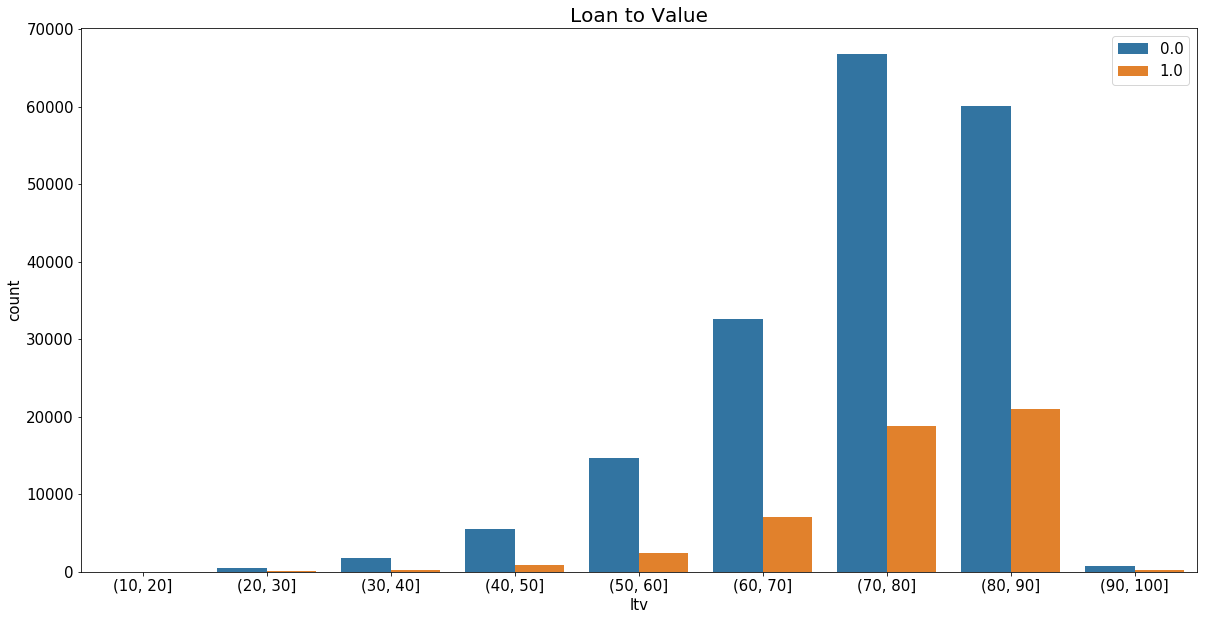

In [186]:
# bureau_df = train.loc[:,['perform_cns.score', 'loan_default']]
# bureau_df['perform_cns.score'] = pd.cut(x=bureau_df['perform_cns.score'], bins=np.arange(0, 1000, 100), include_lowest=True)
# bureau_df.head()
# fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
fig = plt.subplots(figsize=(20, 10))
b = sns.countplot(x = "ltv", data=ltv_df, hue = "loan_default")
b.set_title('Loan to Value', fontsize=20)
b.set_xlabel("ltv", fontsize=15)
b.set_ylabel("count", fontsize=15)
b.tick_params(labelsize=15)
b.legend(fontsize=15)
# plt.savefig("ltv.png")



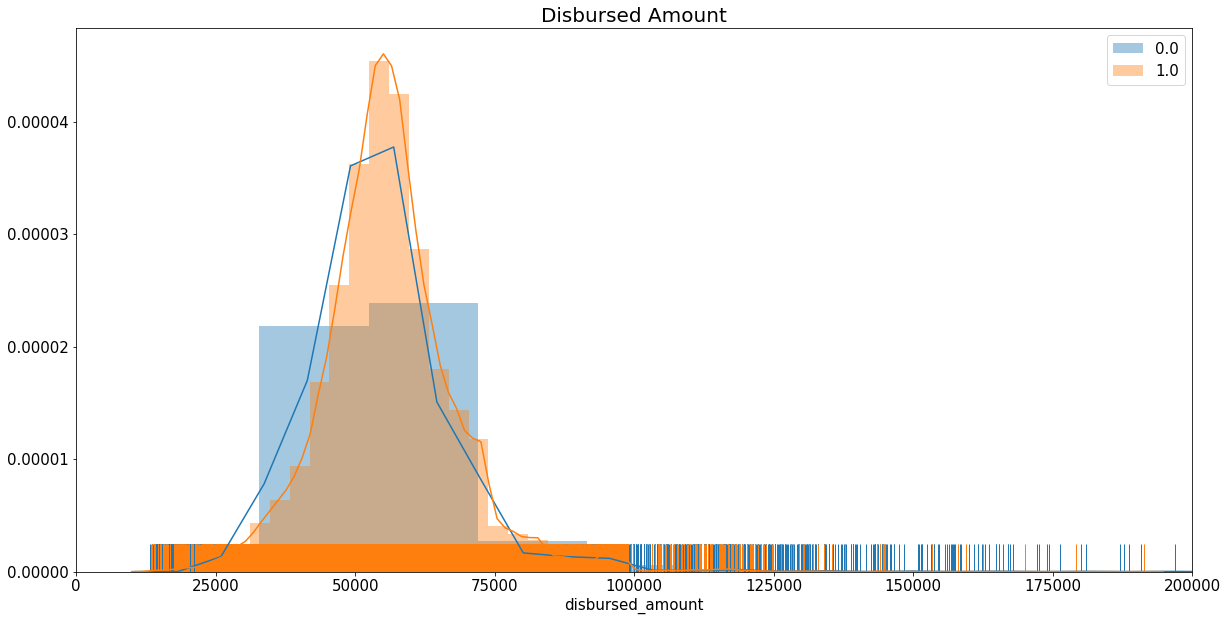

In [187]:
fig = plt.subplots(figsize=(20, 10))
sns.distplot(train.loc[train['loan_default'] == 0, 'disbursed_amount'], rug=True, label = '0.0')
sns.distplot(train.loc[train['loan_default'] == 1, 'disbursed_amount'], rug=True, label = '1.0')
plt.xlim(0, 200000)
plt.xlabel("disbursed_amount", fontsize=15)
plt.legend(fontsize=15)
plt.title('Disbursed Amount', fontsize=20)
plt.tick_params(labelsize=15)
# plt.savefig("disbursed.png")

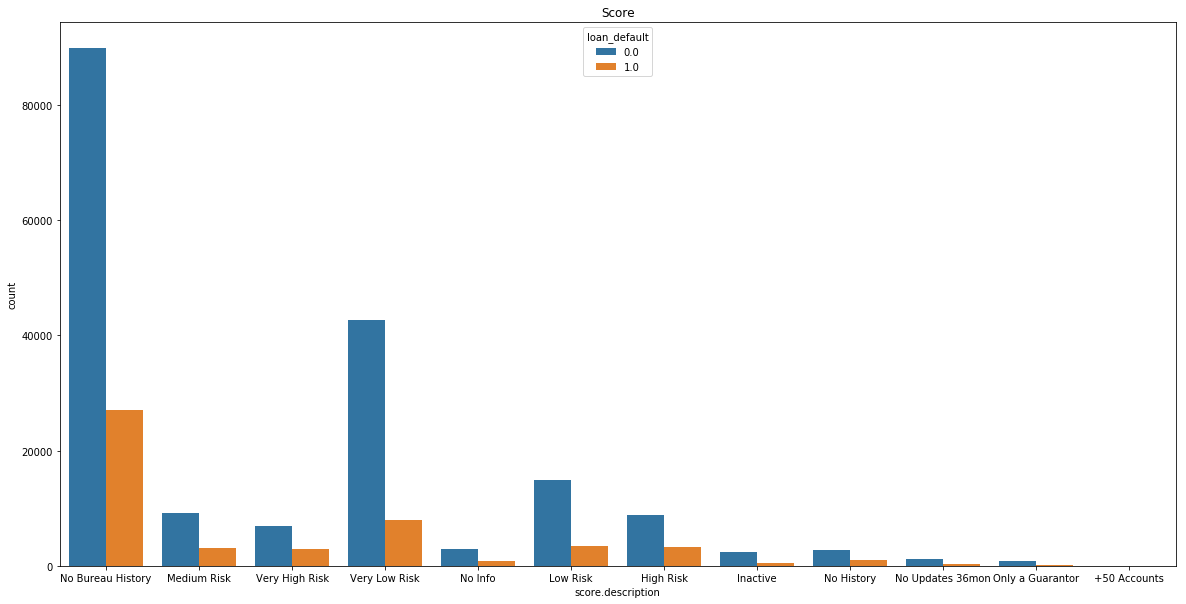

In [188]:
fig = plt.subplots(figsize=(20, 10))
sns.countplot(x = "score.description", data=train, hue = "loan_default").set_title('Score');

In [189]:
scores = train.groupby(['loan_default', 'score.description']).uniqueid.count().reset_index()
default_num = train[train['loan_default'] == 1].shape[0] #1: 50,611
no_default_num = train[train['loan_default'] == 0].shape[0] #0: 182,543
scores['percent'] = round(scores['uniqueid']/no_default_num, 2)*100
scores.loc[scores['loan_default'] == 1, 'percent'] = round(scores['uniqueid']/default_num, 2)*100
scores
default_pivot = pd.pivot_table(scores, values = 'percent', index = 'loan_default', columns = 'score.description', aggfunc=np.sum)
default_pivot

score.description,+50 Accounts,High Risk,Inactive,Low Risk,Medium Risk,No Bureau History,No History,No Info,No Updates 36mon,Only a Guarantor,Very High Risk,Very Low Risk
loan_default,,,,,,,,,,,,
0.0,0.0,5.0,1.0,8.0,5.0,49.0,2.0,2.0,1.0,0.0,4.0,23.0
1.0,NaN,6.0,1.0,7.0,6.0,53.0,2.0,2.0,1.0,0.0,6.0,16.0


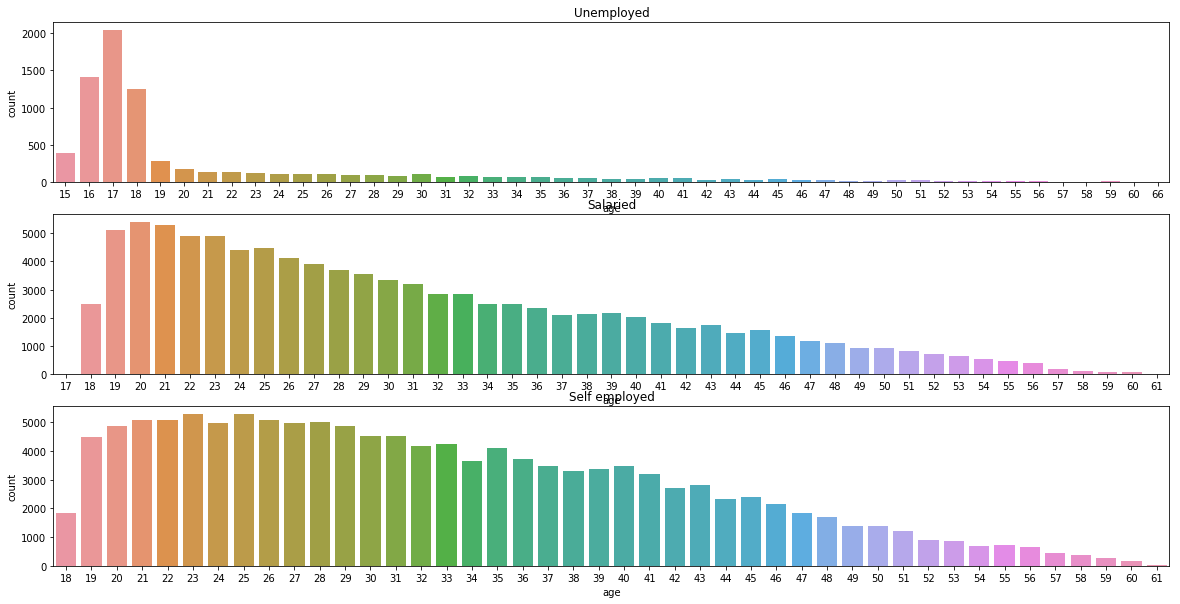

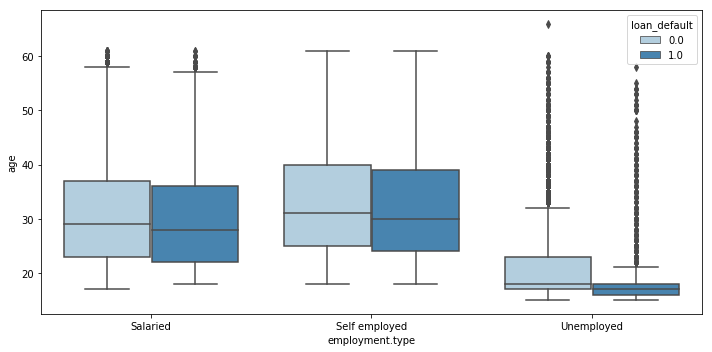

In [190]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
sns.countplot(ax = ax1, x = "age", data=train[train['employment.type'] == 'Unemployed']).set_title('Unemployed');
sns.countplot(ax = ax2, x = "age", data=train[train['employment.type'] == 'Salaried']).set_title('Salaried');
sns.countplot(ax = ax3, x = "age", data=train[train['employment.type'] == 'Self employed']).set_title('Self employed');
fig, ax4 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.boxplot(ax = ax4, y="age", x= "employment.type", hue = "loan_default", palette="Blues", data = train)
plt.tight_layout(); 

## Prepare data for train

In [191]:
#need to handle between class imbalance
X = train.drop(['loan_default', 'employment.type', 'score.description', 'current_pincode_id', 'uniqueid'], axis = 1)
Y = train['loan_default']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

## GBM Classifier

## Imbalance data as is

The train set R^2 is 0.784
The test set R^2 is 0.783
[[54697    59]
 [15104    87]]
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88     54756
         1.0       0.60      0.01      0.01     15191

   micro avg       0.78      0.78      0.78     69947
   macro avg       0.69      0.50      0.44     69947
weighted avg       0.74      0.78      0.69     69947

F1 is 0.01
ROC gini is 0.29
Precision Recall gini is -0.35


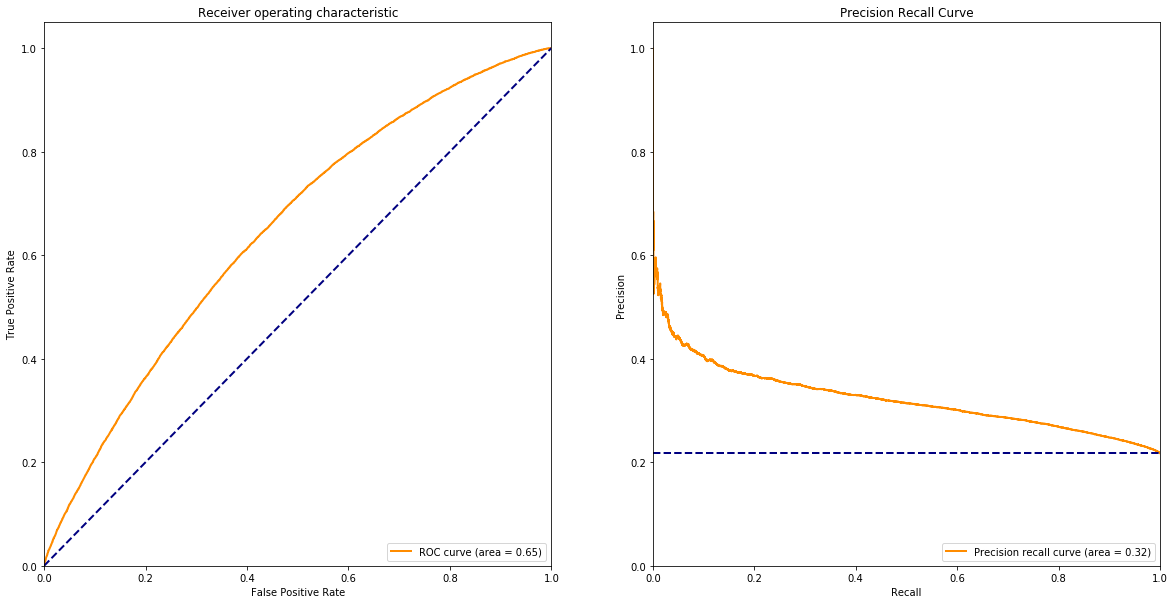

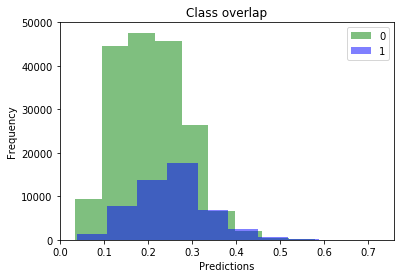

In [87]:
gbm = GradientBoostingClassifier(random_state = 42)
gbm.fit(X_train, Y_train)
print("The train set R^2 is %.3f" %(gbm.score(X_train, Y_train)))
print("The test set R^2 is %.3f" %(gbm.score(X_test,Y_test)))

Y_pred = gbm.predict(X_test)
Y_prob = gbm.predict_proba(X_test)[:,1]

fun.get_report(Y_test, Y_pred)
fun.ROC_graph(Y_test, Y_pred, Y_prob)

preds = pd.DataFrame(data = np.array(Y), columns = ['class'])
preds['pred'] = gbm.predict_proba(X)[:,1]

x1 = preds.loc[preds['class'] ==0, 'pred']
x2 = preds.loc[preds['class'] ==1, 'pred']

fun.class_overlap(x1, x2)

## Imbalanced data: up sampling

The train set R^2 is 0.613
The test set R^2 is 0.610
[[30277 24336]
 [18423 36490]]
              precision    recall  f1-score   support

         0.0       0.62      0.55      0.59     54613
         1.0       0.60      0.66      0.63     54913

   micro avg       0.61      0.61      0.61    109526
   macro avg       0.61      0.61      0.61    109526
weighted avg       0.61      0.61      0.61    109526

F1 is 0.63
ROC gini is 0.30
Precision Recall gini is 0.27


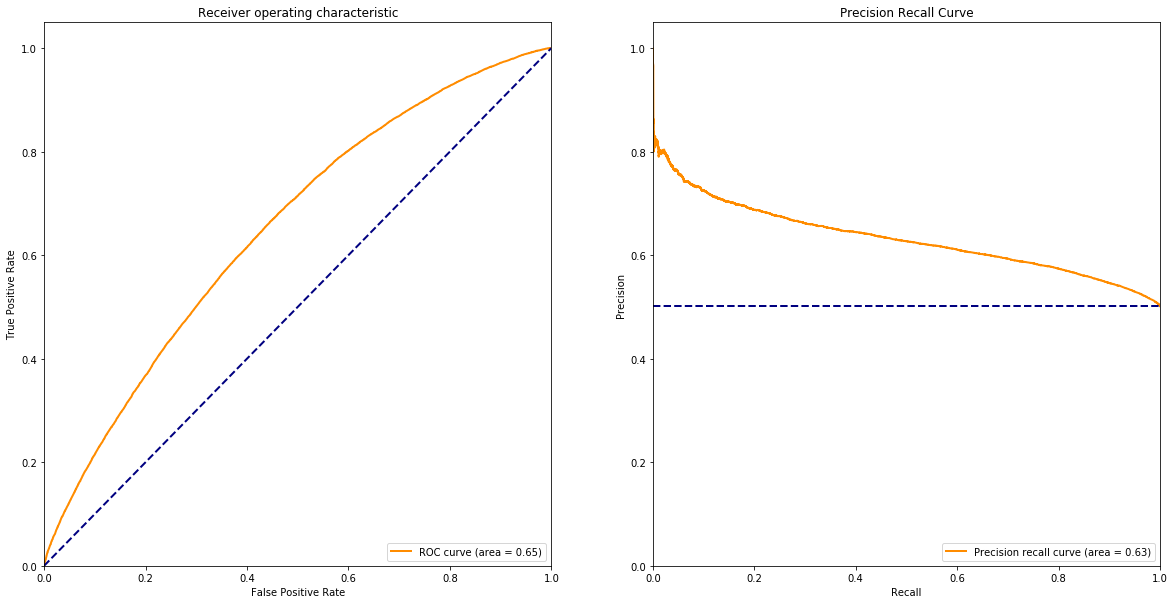

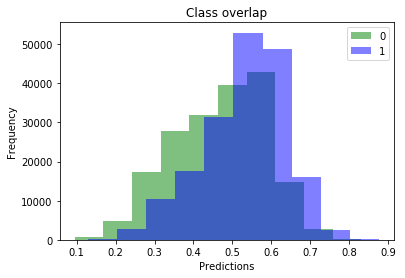

In [10]:
X = train.drop(['aadhar_flag', 'branch_id', 'supplier_id', 'employee_code_id', 'loan_default', 'employment.type', 'score.description', 'current_pincode_id', 'uniqueid'], axis = 1)
Y = train['loan_default']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

gbm = GradientBoostingClassifier(random_state = 42)
gbm.fit(X_train, Y_train)

conf_mat = confusion_matrix(Y, gbm.predict(X))
positives = sum(conf_mat[0])
negatives = sum(conf_mat[1])
minorIndex = train[train['loan_default']==1].uniqueid.values
resampled = resample(minorIndex, n_samples = positives-negatives)
LEFT = pd.DataFrame(list(train.uniqueid) + list(resampled), columns=['INDEX'])
train2 = pd.merge(LEFT, train, how='left', left_on ='INDEX', right_on='uniqueid')

X = train2.drop(['aadhar_flag', 'branch_id', 'supplier_id', 'employee_code_id', 'INDEX', 'loan_default', 'employment.type', 'score.description', 'current_pincode_id', 'uniqueid'], axis = 1)
Y = train2['loan_default']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

gbm.fit(X_train, Y_train)
print("The train set R^2 is %.3f" %(gbm.score(X_train, Y_train)))
print("The test set R^2 is %.3f" %(gbm.score(X_test,Y_test)))

Y_pred = gbm.predict(X_test)
Y_prob = gbm.predict_proba(X_test)[:,1]

fun.get_report(Y_test, Y_pred)
fun.ROC_graph(Y_test, Y_pred, Y_prob)

preds = pd.DataFrame(data = np.array(Y), columns = ['class'])
preds['pred'] = gbm.predict_proba(X)[:,1]

x1 = preds.loc[preds['class'] ==0, 'pred']
x2 = preds.loc[preds['class'] ==1, 'pred']

fun.class_overlap(x1, x2)



0.02702702702702703
0.00794263253986012
[0.00013451 0.00013769 0.00014086 0.00014403]
[[101746  80797]
 [ 60767 121776]]
              precision    recall  f1-score   support

         0.0       0.63      0.56      0.59    182543
         1.0       0.60      0.67      0.63    182543

   micro avg       0.61      0.61      0.61    365086
   macro avg       0.61      0.61      0.61    365086
weighted avg       0.61      0.61      0.61    365086



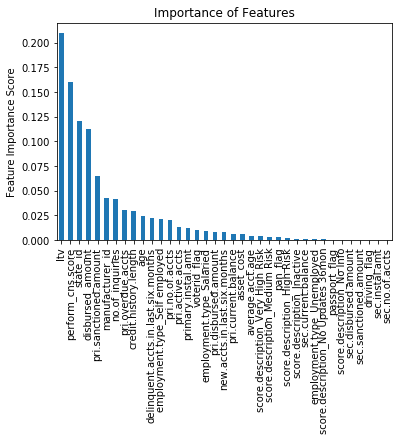

In [11]:
predictors=list(X_train)
feat_imp = pd.Series(gbm.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[feat_imp > 0]

print(feat_imp.mean())
print(np.median(feat_imp))
x = np.arange(0,1,0.25)
print(np.percentile(feat_imp, q = x))
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

pred = gbm.predict(X)
prob = gbm.predict_proba(X)[:,1]

fun.get_report(Y, pred)

The train set R^2 is 0.878
The test set R^2 is 0.793
 ------------ TEST --------------
[[40144 14469]
 [ 8218 46695]]
              precision    recall  f1-score   support

         0.0       0.83      0.74      0.78     54613
         1.0       0.76      0.85      0.80     54913

   micro avg       0.79      0.79      0.79    109526
   macro avg       0.80      0.79      0.79    109526
weighted avg       0.80      0.79      0.79    109526

F1 is 0.80
ROC gini is 0.78
Precision Recall gini is 0.79


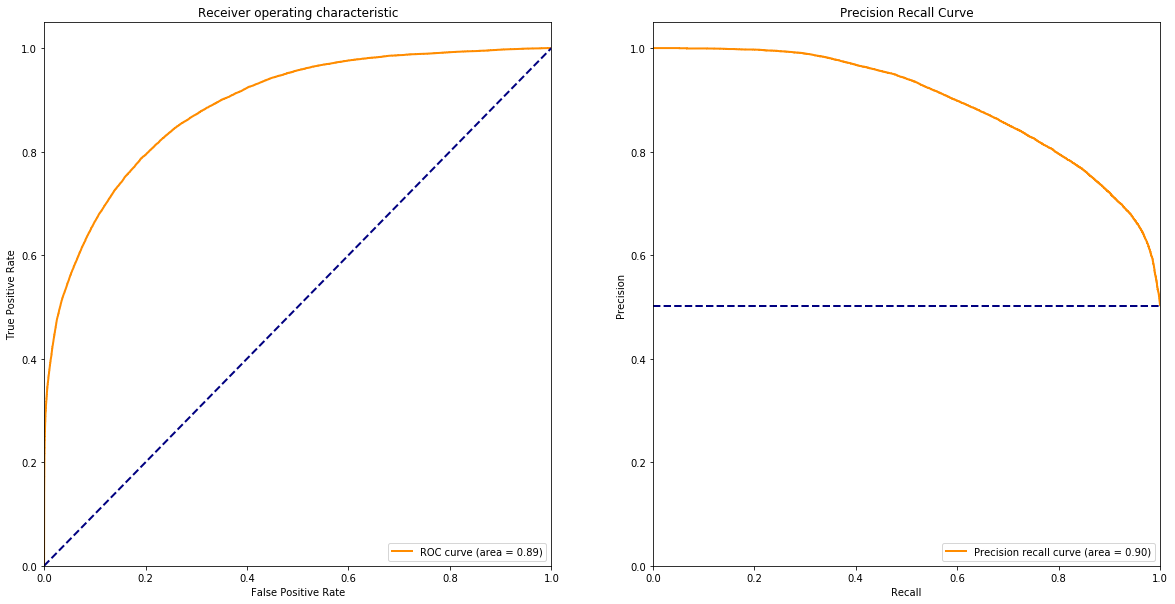

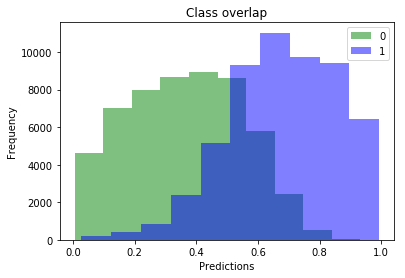

 ------------ TRAIN --------------
[[108695  19235]
 [ 11941 115689]]
              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87    127930
         1.0       0.86      0.91      0.88    127630

   micro avg       0.88      0.88      0.88    255560
   macro avg       0.88      0.88      0.88    255560
weighted avg       0.88      0.88      0.88    255560

F1 is 0.88
ROC gini is 0.92
Precision Recall gini is 0.92


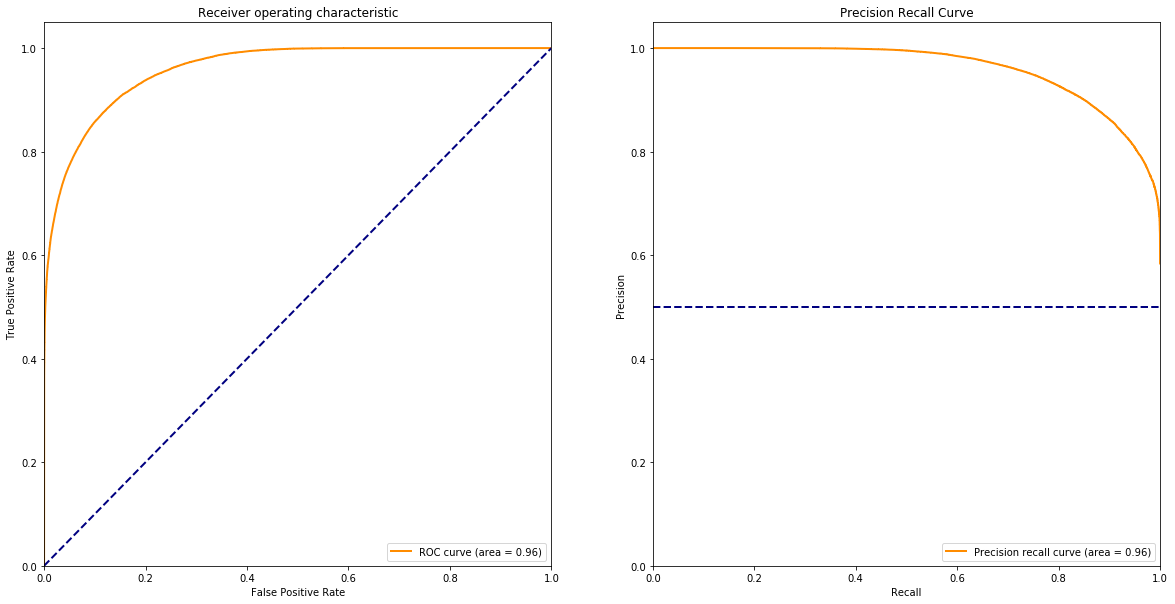

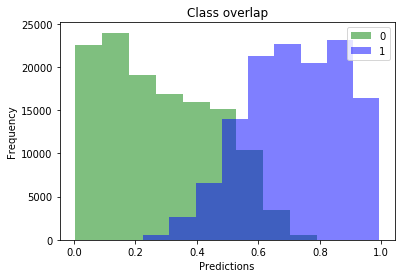

--- 1207.3647396564484 seconds ---


In [46]:
import time
start_time = time.time()

#With Important features
# feat_imp2 = feat_imp[feat_imp > 0]
# cols = feat_imp2.index
cols = feat_imp.index
X_train = X_train[cols]
X_test = X_test[cols]
X = X[cols]



# The train set R^2 is 0.727
# The test set R^2 is 0.680

# The train set R^2 is 0.612
# The test set R^2 is 0.608


# The train set R^2 is 0.611
# The test set R^2 is 0.608

# gbm.set_params(n_estimators=80, max_depth = 15)
gbm = GradientBoostingClassifier(random_state = 42, n_estimators=80, max_depth = 15, max_features = 'sqrt') #n_estimators=65, 
gbm.fit(X_train, Y_train)

print("The train set R^2 is %.3f" %(gbm.score(X_train, Y_train)))
print("The test set R^2 is %.3f" %(gbm.score(X_test,Y_test)))
print(" ------------ TEST --------------")
Y_pred = gbm.predict(X_test)
Y_prob = gbm.predict_proba(X_test)[:,1]

fun.get_report(Y_test, Y_pred)
fun.ROC_graph(Y_test, Y_pred, Y_prob)

preds = pd.DataFrame(data = np.array(Y_test), columns = ['class'])
preds['pred'] = gbm.predict_proba(X_test)[:,1]

x1 = preds.loc[preds['class'] ==0, 'pred']
x2 = preds.loc[preds['class'] ==1, 'pred']

fun.class_overlap(x1, x2)

print(" ------------ TRAIN --------------")
Y_pred = gbm.predict(X_train)
Y_prob = gbm.predict_proba(X_train)[:,1]

fun.get_report(Y_train, Y_pred)
fun.ROC_graph(Y_train, Y_pred, Y_prob)

preds = pd.DataFrame(data = np.array(Y_train), columns = ['class'])
preds['pred'] = gbm.predict_proba(X_train)[:,1]

x1 = preds.loc[preds['class'] ==0, 'pred']
x2 = preds.loc[preds['class'] ==1, 'pred']

fun.class_overlap(x1, x2)

gbm.fit(X, Y)

print(" ------------- ALL ---------------")
print("The R^2 is %.3f" %(gbm.score(X, Y)))

Y_pred = gbm.predict(X)
Y_prob = gbm.predict_proba(X)[:,1]

fun.get_report(Y, Y_pred)
fun.ROC_graph(Y, Y_pred, Y_prob)

preds = pd.DataFrame(data = np.array(Y), columns = ['class'])
preds['pred'] = gbm.predict_proba(X)[:,1]

x1 = preds.loc[preds['class'] ==0, 'pred']
x2 = preds.loc[preds['class'] ==1, 'pred']

fun.class_overlap(x1, x2)

print("--- %s seconds ---" % (time.time() - start_time))

## Tuning

In [21]:


gbm2 = GradientBoostingClassifier(random_state = 42)
gbm2
# gbm.fit(X_train[cols2], Y_train)
# prob = gbm.predict_proba(X_test[cols2])[:,1]

# fpr, tpr, thresholds = roc_curve(Y_test, prob)
# auc(fpr, tpr)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [44]:
feat_imp2 = feat_imp[feat_imp > 0.02]
cols2 = feat_imp2.index

# params = {'min_samples_split':range(2, 120, 20)} #100

depth = range(7,20,2)
# depth = [1, 2, 3, 4, 5]
train_error2 = []
test_error2 = []
area = []

# max_depth = 15
gbm2 = GradientBoostingClassifier(random_state = 42, n_estimators=80)

for i in depth:
    gbm2.set_params(max_features = i)
    gbm2.fit(X_train[cols2], Y_train)
    train_error2.append(gbm2.score(X_train[cols2], Y_train))
    test_error2.append(gbm2.score(X_test[cols2], Y_test))

    prob = gbm2.predict_proba(X_test[cols2])[:,1]
    
    fpr, tpr, thresholds = roc_curve(Y_test, prob)
    area.append(auc(fpr, tpr))
    
plt.plot(depth, train_error2, c='red', label='training error')
plt.plot(depth, test_error2, c='blue', label='test error')
plt.legend()
plt.show()

plt.plot(depth, area, c='blue', label='test error')
plt.legend()
plt.show()

ValueError: max_features must be in (0, n_features]

In [84]:
feat_imp2 = feat_imp[feat_imp > 0.02]
cols2 = feat_imp2.index
params = {'min_samples_split':range(2, 120, 20)} #100
gbm.set_params(n_estimators=80)
grid = GridSearchCV(gbm, params, scoring='roc_auc', n_jobs=2, iid=False, cv=5)
grid.fit(X_train[cols], Y_train)
grid.cv_results_, grid.best_params_, grid.best_score_

KeyboardInterrupt: 